# Random Forests
***

In this notebook we will approach the prediction problem using Random Forests. 

There is an introductory section on random forests, condensed from *An introduction to Statistical Learning* by G. James, D. Witten, T. Hastie, and R. Tibshirani.

In [62]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR,
       RandomForestClassifier as RFC)
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

from extraFunctions import *

SEED = 42

## Theory
***

### Regression Trees
***

We  discuss the process of building a regression tree. Roughly speaking, there are two steps.
1. We divide the predictor space - that is, the set of possible values for $X_1, X_2, \ldots, X_p$ - into $J$ distinct and non-overlapping regions (high-dimensional rectangles), $R_1, R_2, \ldots, R_J$.
2. For every observation that falls into the region $R_j$, we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$.

The goal is to find boxes $R_1, \ldots, R_J$ that minimize the RSS, given by
$$
\sum_{j=1}^J \sum_{i \in R_j}\left(y_i-\hat{y}_{R_j}\right)^2,
$$
where $\hat{y}_{R_j}$ is the mean response for the training observations within the $j$ th box. 

<!-- We take a top-down, greedy approach that is known as recursive binary splitting. It begins at the top of the tree (at which point all observations belong to a single region) and then successively splits the predictor space; each split is indicated via two new branches further down on the tree. It is greedy because at each step of the tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some future step. -->

In detail, for any $j$ and $s$, we define the pair of half-planes
$$
R_1(j, s)=\left\{X \mid X_j<s\right\} \text { and } R_2(j, s)=\left\{X \mid X_j \geq s\right\}
$$
and we seek the value of $j$ and $s$ that minimize the equation
$$
\sum_{i: x_i \in R_1(j, s)}\left(y_i-\hat{y}_{R_1}\right)^2+\sum_{i: x_i \in R_2(j, s)}\left(y_i-\hat{y}_{R_2}\right)^2,
$$
where $\hat{y}_{R_1}$ is the mean response for the training observations in $R_1(j, s)$, and $\hat{y}_{R_2}$ is the mean response for the training observations in $R_2(j, s)$. Finding the values of $j$ and $s$ that minimize can be done quite quickly, especially when the number of features $p$ is not too large.

Next, we repeat the process, looking for the best predictor and best cutpoint in order to split the data further so as to minimize the RSS within each of the resulting regions. However, this time, instead of splitting the entire predictor space, we split one of the two previously identified regions. We now have three regions. Again, we look to split one of these three regions further, so as to minimize the RSS. The process continues until a stopping criterion is reached; for instance, we may continue until no region contains more than five observations.

The process described above is likely to overfit. Therefore, we grow a very large tree $T_0$, and prune it back in order to obtain a subtree that leads to the lowest test error rate. 

Cost complexity pruning - also known as weakest link pruning - gives us a way to do this. We consider a sequence of trees indexed by a nonnegative tuning parameter $\alpha$, for which there corresponds a subtree $T \subset T_0$ such that
$$
\sum_{m=1}^{|T|} \sum_{i: x_i \in R_m}\left(y_i-\hat{y}_{R_m}\right)^2+\alpha|T|
$$
is as small as possible. Here $|T|$ indicates the number of terminal nodes of the tree $T, R_m$ is the rectangle (i.e. the subset of predictor space) corresponding to the $m$ th terminal node, and $\hat{y}_{R_m}$ is the predicted response associated with $R_m$. As $\alpha$ increases, there is a price to pay for having a tree with many terminal nodes, and so the quantity above will tend to be minimized for a smaller subtree. It is reminiscent of the lasso.

**Algorithm: Building a Regression Tree:**
1. Use recursive binary splitting to grow a large tree on the training data, stopping only when each terminal node has fewer than some minimum number of observations.
2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtrees, as a function of $\alpha$.
3. Use K-fold cross-validation to choose $\alpha$. That is, divide the training observations into $K$ folds. For each $k=1, \ldots, K$ :
    - (a) Repeat Steps 1 and 2 on all but the $k$ th fold of the training data.
    - (b) Evaluate the mean squared prediction error on the data in the left-out $k$ th fold, as a function of $\alpha$.
Average the results for each value of $\alpha$, and pick $\alpha$ to minimize the average error.
4. Return the subtree from Step 2 that corresponds to the chosen value of $\alpha$.

### Classification Trees
***
In the classification setting, RSS cannot be used as a criterion for making the binary splits. A natural alternative to RSS is the classification error rate, which is the fraction of the training observations in that region that do not belong to the most common class:
$$
E=1-\max _k\left(\hat{p}_{m k}\right) .
$$

Here $\hat{p}_{m k}$ represents the proportion of training observations in the $m$ th region that are from the $k$ th class. However, it turns out that classification error is not sufficiently sensitive for tree-growing.

An alternative is the Gini index is defined by
$$
G=\sum_{k=1}^K \hat{p}_{m k}\left(1-\hat{p}_{m k}\right),
$$
a measure of total variance across the $K$ classes. It is not hard to see a measure of total variance across the $K$ classes. It is not hard to see that the Gini index takes on a small value if all of the $\hat{p}_{m k}$ 's are close to zero or one. For this reason the Gini index is referred to as a measure of node purity.

### Bagging 
***

The decision trees discussed so far suffer from high variance. Bootstrap aggregation, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method.

Recall that given a set of $n$ independent observations $Z_1, \ldots, Z_n$, each with variance $\sigma^2$, the variance of the mean $\bar{Z}$ of the observations is given by $\sigma^2 / n$. Hence a natural way to reduce the variance and increase the test set accuracy of a statistical learning method is to take many training sets from the population, build a separate prediction model using each training set. This is not practical because we generally do not have access to multiple training sets. Instead, we can bootstrap, by taking repeated samples from the (single) training data set. In this approach we generate $B$ different bootstrapped training data sets. We then train our method on the $b$ th bootstrapped training set in order to get $\hat{f}^{* b}(x)$, and finally average all the predictions, to obtain
$$
\hat{f}_{\mathrm{bag}}(x)=\frac{1}{B} \sum_{b=1}^B \hat{f}^{* b}(x) .
$$

To apply bagging to regression trees, we simply construct $B$ regression trees using $B$ bootstrapped training sets, and average the resulting predictions. These trees are grown deep, and are not pruned. Hence each individual tree has high variance, but low bias. Averaging these $B$ trees reduces the variance. When $Y$ is qualitative, we can record the class predicted by each of the $B$ trees, and take a majority vote: the overall prediction is the most commonly occurring class among the $B$ predictions.

### Random Forests 
***

Random forests provide an improvement over bagged trees by way of a small tweak that decorrelates the trees. As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split is considered, a random sample of $m$ predictors is chosen as split candidates from the full set of $p$ predictors. A fresh sample of $m$ predictors is taken at each split, and typically we choose $m \approx \sqrt{p}$, where $p$ is the the total number of predictors.

The rationale is as follows: Suppose that there is one very strong predictor in the data set, along with a number of other moderately strong predictors. Then in the collection of bagged trees, most or all of the trees will use this strong predictor in the top split. Consequently, all of the bagged trees will look quite similar to each other. Hence the predictions from the bagged trees will be highly correlated. In particular, this means that bagging alone will not lead to a substantial reduction in variance over a single tree in this setting.

### Boosting 
***

Boosting works in a similar way to Bagging except that the trees are grown sequentially: each tree is grown using information from previously grown trees. In particular, boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

**Algorithm: Boosting for Regression Trees**
1. Set $\hat{f}(x)=0$ and $r_i=y_i$ for all $i$ in the training set.
2. For $b=1,2, \ldots, B$, repeat:
    - (a) Fit a tree $\hat{f}^b$ with $d$ splits $(d+1$ terminal nodes) to the training data $(X, r)$.
    - (b) Update $\hat{f}$ by adding in a shrunken version of the new tree:
    $$
    \hat{f}(x) \leftarrow \hat{f}(x)+\lambda \hat{f}^b(x) .
    $$
    - (c) Update the residuals,
$$
r_i \leftarrow r_i-\lambda \hat{f}^b\left(x_i\right)
$$
3. Output the boosted model,
$$
\hat{f}(x)=\sum_{b=1}^B \lambda \hat{f}^b(x) .
$$

One can get a boosting algorithm for classification and more generally for learning methods with differentiable loss function functions. The algorithm for these cases is much the same as above, but the residuals are derived by differentiating the loss function, hence the name *Gradient Boosting*.

A popular extension is to use the XGBOOST algorithm. In essence, this follows the same algorithm as above, except each tree in part 2 of the algorithm above is generated and pruned in a clever way.

# Application
***
### The Titanic Data Set
***

First we load the data.

In [63]:
train = pd.read_csv('data/processedTrain.csv')
test  = pd.read_csv('data/processedTest.csv')

drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

y = train['Survived'].values
X = StandardScaler().fit_transform(train.drop(columns=drop_cols))
X_test  = StandardScaler().fit_transform(test.drop(columns=drop_cols))

X_train, X_cv, y_train, y_cv = skm.train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Classifier
***
We will begin by using a standard Random Forest classifier.

In [64]:
model = RFC(n_estimators=1000, max_depth=5, random_state=SEED)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=42)

The fraction of correct predictions is 0.85
The precision is 0.84
The recall is 0.78
The specificity is 0.85


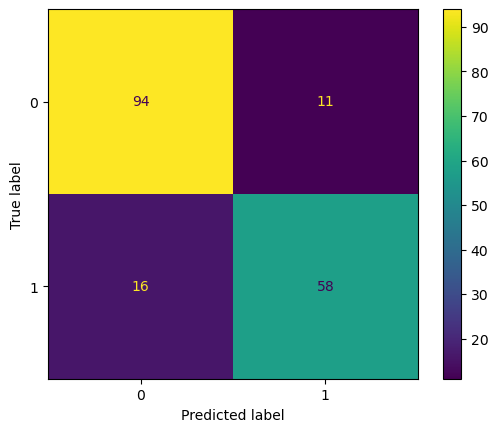

In [65]:
confusionMatrix(model,X_cv,y_cv)

In [66]:
model = RFC(n_estimators=1000, max_depth=5, random_state=SEED)
model.fit(X, y)
saveSubmission(model, X_test, test, 'submissionRF')

Your submission was successfully saved!


... This is already as good (if not better) than the SVM approach. In fact, we get an 0.8 score for a submission with this. Let's see if we can improve! Let's mess around with the parameters a bit.

In [67]:
model = RFC(criterion='gini', 
            min_samples_split=4,
            min_samples_leaf=5,
            oob_score=True,
            random_state=SEED,
            n_jobs=-1,
            verbose=0)

# Round 1
# # Create grid for searching
# rf_param_grid = {
#     'n_estimators' : [900,1000,1100,1200],
#     'max_depth': [3,5,7,9],
# }

# Round 2
# Create grid for searching
rf_param_grid = {
    'n_estimators' : [900],
    'max_depth': [6,7,8],
}

# Perform random search
rf_random = RandomizedSearchCV(param_distributions=rf_param_grid, 
                                    estimator = model, scoring = "accuracy", 
                                    verbose = 0, n_iter = 50, cv = 5)

# Fit to the data
rf_random.fit(X_train, y_train)

print("Best parameters found: ", rf_random.best_params_)
print("Best accuracy found: ", rf_random.best_score_)

/Users/osianshelley/opt/anaconda3/envs/statisticalLearning/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=50. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'n_estimators': 900, 'max_depth': 7}
Best accuracy found:  0.8440756426671919


The fraction of correct predictions is 0.87
The precision is 0.86
The recall is 0.81
The specificity is 0.87


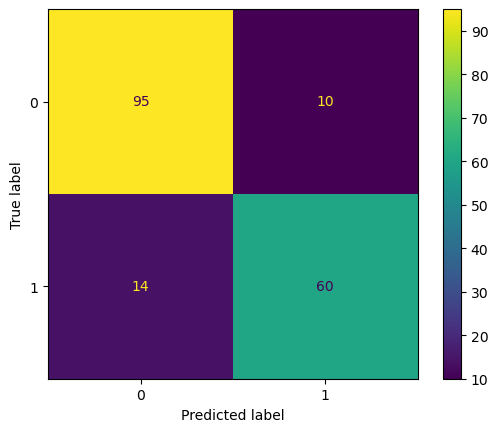

In [68]:
confusionMatrix(rf_random,X_cv,y_cv)

The best parameters we've found give a score of 81% on Kaggle! The model below gives a slightly higher score, but was deduced from fiddling with my submissions.

In [69]:
model = RFC(criterion='gini', 
            n_estimators=1100,
            max_depth=5,
            min_samples_split=4,
            min_samples_leaf=5,
            oob_score=True,
            random_state=SEED,
            n_jobs=-1,
            verbose=0)
model.fit(X,y)
saveSubmission(model,X_test,test,'submissionRFTuned')

Your submission was successfully saved!


### XGBOOST
***
Finally we have a go at using XGBOOST:

In [76]:
# # Round 1
# # Create the parameter grid: gbm_param_grid 
# gbm_param_grid = {
#     'max_depth': [4,8,6,10],
#     'gamma': [0,0.25,1.0],
#     'reg_lambda': [0,1.0,10.0],
#     'learning_rate': [.01,0.05,0.1],
#     'scale_pos_weight': [1,3,5]
# }
# {'scale_pos_weight': 1, 'reg_lambda': 10.0, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.25}

# Round 2
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'max_depth': [5,6,7],
    'gamma': [0,0.25,0.5],
    'reg_lambda': [7.5,10.0,12,5],
    'learning_rate': [0.005,.01,0.015],
    'scale_pos_weight': [0.5,1,1.5]
}

# Instantiate the regressor: gbm
gbm = XGBClassifier(n_estimators=1000)

# Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 0, n_iter = 50, cv = 5)


# Fit randomized_mse to the data
xgb_random.fit(X_train, y_train)

print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)

The fraction of correct predictions is 0.85
The precision is 0.82
The recall is 0.82
The specificity is 0.88


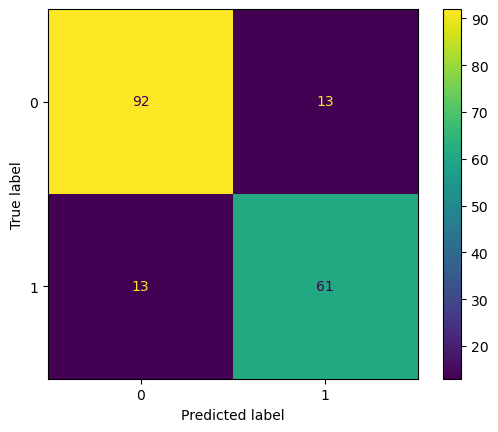

In [75]:
confusionMatrix(xgb_random,X_cv,y_cv)

In [ ]:
gbm = XGBClassifier( n_estimators=1100,

            max_depth=5,
            min_samples_split=4,
            min_samples_leaf=5,
            oob_score=True,
            random_state=SEED,
            n_jobs=-1,
            verbose=0)
model.fit(X,y)
saveSubmission(model,X_test,test,'submissionRFTuned')